In [127]:
import torch
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

In [128]:
num_classes = 5

X, y = make_blobs(n_samples = 2000, n_features = 2, centers=num_classes, cluster_std = 1.0, random_state = 42)
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2000, 2) (2000,)
(1600, 2) (400, 2) (1600,) (400,)


In [129]:
type(X_train), type(X_test)

(numpy.ndarray, numpy.ndarray)

In [130]:
X_train, X_test, y_train, y_test = torch.from_numpy(X_train).type(torch.float), torch.from_numpy(X_test).type(torch.float), torch.from_numpy(y_train).type(torch.float), torch.from_numpy(y_test).type(torch.float)

In [131]:
type(X_train), type(X_test), type(y_train), type(y_test)

(torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor)

In [132]:
X_train[0], y_train[0]

(tensor([-8.4662,  7.7127]), tensor(3.))

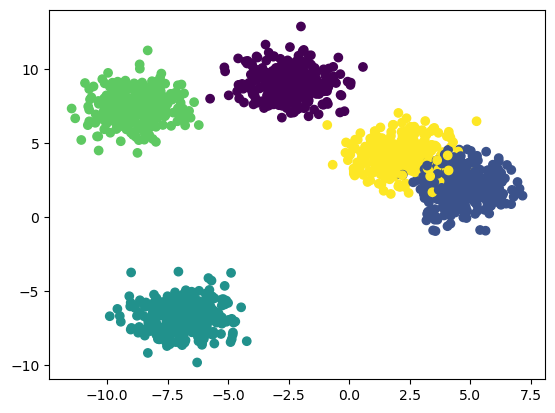

In [133]:
plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train)
plt.show()

In [134]:
class BlobModel(nn.Module):
    def __init__(self, infeatures, outfeatures):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(infeatures, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, outfeatures)
        )
    
    def forward(self, x):
        return self.mlp(x)

device = "cpu"
blobModel = BlobModel(infeatures = 2, outfeatures = 5).to(device)
blobModel

BlobModel(
  (mlp): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=5, bias=True)
  )
)

In [135]:
y_pred = blobModel(X_test)
y_pred[:10], y_test[:10]

(tensor([[-4.3920e-01,  1.8924e-01, -1.9970e-01,  2.2220e-01,  2.4810e-01],
         [-4.7945e-01,  2.0266e-01, -2.3921e-01,  2.2847e-01,  2.8013e-01],
         [-4.3601e-02,  2.8911e-01,  8.8904e-05,  4.1701e-01, -4.6845e-02],
         [-4.6163e-01,  1.9659e-01, -2.5527e-01,  2.2197e-01,  2.4900e-01],
         [-4.6876e-01,  1.9658e-01, -2.4779e-01,  2.2914e-01,  2.5903e-01],
         [-1.6006e-02,  2.1036e-01,  2.6257e-02,  2.8665e-01, -1.1801e-01],
         [-2.4780e-01,  3.0015e-01, -2.2918e-01,  3.3845e-01,  1.0288e-01],
         [-1.7524e-01,  2.4087e-01, -1.3712e-01,  3.2100e-01,  1.8406e-02],
         [-6.9577e-02,  1.4991e-01,  6.8863e-02,  2.1564e-01, -1.2037e-01],
         [-4.1844e-01,  1.7977e-01, -1.9869e-01,  2.2133e-01,  2.1879e-01]],
        grad_fn=<SliceBackward0>),
 tensor([3., 3., 1., 3., 3., 1., 2., 2., 4., 3.]))

## Some important Info

It is good to create Train Dataloader and Test DataLoader

During Testing - We're not updating weights — just evaluating. So there's no benefit to shuffling. Hence shuffle is 
set to False when testing.

loop.set_postfix(loss=loss.item()) updates the progress bar display with the current loss value. This gives you a live, readable update during training without having to print stuff every iteration.

In [138]:
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

lossFn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = blobModel.parameters(), lr = 0.01)
epochs = 50

X_train_tensor = torch.tensor(X_train, dtype = torch.float32)
y_train_tensor = torch.tensor(y_train, dtype = torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

trainDataset = TensorDataset(X_train_tensor, y_train_tensor)
trainLoader = DataLoader(trainDataset, batch_size = 32, shuffle = True)

testDataset = TensorDataset(X_test_tensor, y_test_tensor)
testLoader = DataLoader(testDataset, batch_size = 32, shuffle = False)

for each_epoch in range(epochs):

    blobModel.train()

    running_loss = 0.0
    loop = tqdm(trainLoader,  desc=f"Epoch [{each_epoch+1}/{epochs}]")

    for batchX, batchY in loop:
        batchX, batchY = batchX.to(device), batchY.to(device)
        output = blobModel(batchX)

        optimizer.zero_grad()
        lossVal = lossFn(output, batchY)
        lossVal.backward()
        optimizer.step()

        running_loss += lossVal.item()

    avgLoss = running_loss/len(trainLoader)

    testLoss = 0.0
    correct = 0
    total = 0
    blobModel.eval()
    with torch.inference_mode():
        for testbatchX, testBatchY in testLoader:
            testbatchX, testbatchY = testbatchX.to(device), testBatchY.to(device)
            y_pred = blobModel(testbatchX)
            tloss = lossFn(y_pred, testbatchY)
            testLoss += tloss.item()
            predicted = torch.argmax(y_pred, 1)
            correct += (predicted == testbatchY).sum().item()
            total += testbatchY.size(0)
            # break

    avgtestloss = testLoss/len(testLoader)
    accuracy = correct / total

    if each_epoch % 2 == 0:
        print(f" For epoch {each_epoch + 1}, training loss is {avgLoss} and test loss is {avgtestloss}; Test Accuracy: {accuracy*100}")



/var/folders/y8/q2s37ndx6tg3lpzp3vp8xk_r0000gn/T/ipykernel_11061/3815607668.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype = torch.float32)
/var/folders/y8/q2s37ndx6tg3lpzp3vp8xk_r0000gn/T/ipykernel_11061/3815607668.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype = torch.long)
/var/folders/y8/q2s37ndx6tg3lpzp3vp8xk_r0000gn/T/ipykernel_11061/3815607668.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test, d

 For epoch 1, training loss is 0.06398658253019676 and test loss is 0.08842101951058094; Test Accuracy: 98.25


Epoch [3/50]: 100%|██████████| 50/50 [00:00<00:00, 2549.57it/s]


 For epoch 3, training loss is 0.09216228078701533 and test loss is 0.07220656947734264; Test Accuracy: 97.25


Epoch [5/50]: 100%|██████████| 50/50 [00:00<00:00, 2587.48it/s]


 For epoch 5, training loss is 0.05641357147716917 and test loss is 0.056292136307232656; Test Accuracy: 97.75


Epoch [7/50]: 100%|██████████| 50/50 [00:00<00:00, 2631.04it/s]


 For epoch 7, training loss is 0.052960638685617595 and test loss is 0.057291464593548044; Test Accuracy: 97.5


Epoch [9/50]: 100%|██████████| 50/50 [00:00<00:00, 2608.24it/s]


 For epoch 9, training loss is 0.05421125942666549 and test loss is 0.08268346114513966; Test Accuracy: 96.75


Epoch [11/50]: 100%|██████████| 50/50 [00:00<00:00, 2641.18it/s]


 For epoch 11, training loss is 0.05288812560378574 and test loss is 0.06460474016001591; Test Accuracy: 97.75


Epoch [13/50]: 100%|██████████| 50/50 [00:00<00:00, 2605.03it/s]


 For epoch 13, training loss is 0.05296429457142949 and test loss is 0.059155268487162314; Test Accuracy: 97.5


Epoch [15/50]: 100%|██████████| 50/50 [00:00<00:00, 2622.88it/s]


 For epoch 15, training loss is 0.052577993058366704 and test loss is 0.06422459477415451; Test Accuracy: 98.75


Epoch [17/50]: 100%|██████████| 50/50 [00:00<00:00, 2634.18it/s]


 For epoch 17, training loss is 0.052743911498691884 and test loss is 0.06647199478286964; Test Accuracy: 97.5


Epoch [19/50]: 100%|██████████| 50/50 [00:00<00:00, 2634.32it/s]


 For epoch 19, training loss is 0.050948946560383776 and test loss is 0.06542972647226773; Test Accuracy: 97.25


Epoch [21/50]: 100%|██████████| 50/50 [00:00<00:00, 2617.38it/s]


 For epoch 21, training loss is 0.05182030703639612 and test loss is 0.06253048240278776; Test Accuracy: 97.25


Epoch [23/50]: 100%|██████████| 50/50 [00:00<00:00, 2322.14it/s]


 For epoch 23, training loss is 0.05679953176062554 and test loss is 0.09869008357278429; Test Accuracy: 97.0


Epoch [25/50]: 100%|██████████| 50/50 [00:00<00:00, 2234.72it/s]


 For epoch 25, training loss is 0.05226130855910014 and test loss is 0.0787896286839476; Test Accuracy: 97.0


Epoch [27/50]: 100%|██████████| 50/50 [00:00<00:00, 2338.85it/s]


 For epoch 27, training loss is 0.20225637839990668 and test loss is 0.4414506431382436; Test Accuracy: 95.25


Epoch [29/50]: 100%|██████████| 50/50 [00:00<00:00, 2347.20it/s]


 For epoch 29, training loss is 0.06561516752932221 and test loss is 0.08150737804289047; Test Accuracy: 98.25


Epoch [31/50]: 100%|██████████| 50/50 [00:00<00:00, 2357.60it/s]


 For epoch 31, training loss is 0.05826904156943783 and test loss is 0.06213355193344446; Test Accuracy: 97.75


Epoch [33/50]: 100%|██████████| 50/50 [00:00<00:00, 2390.05it/s]


 For epoch 33, training loss is 0.053124699720647185 and test loss is 0.06149797084239813; Test Accuracy: 98.5


Epoch [35/50]: 100%|██████████| 50/50 [00:00<00:00, 2430.13it/s]


 For epoch 35, training loss is 0.05310665403259918 and test loss is 0.07282327788953598; Test Accuracy: 97.25


Epoch [37/50]: 100%|██████████| 50/50 [00:00<00:00, 2389.70it/s]


 For epoch 37, training loss is 0.05255432338453829 and test loss is 0.06842202037716141; Test Accuracy: 97.5


Epoch [39/50]: 100%|██████████| 50/50 [00:00<00:00, 2443.46it/s]


 For epoch 39, training loss is 0.05190777558367699 and test loss is 0.07026863402615373; Test Accuracy: 97.75


Epoch [41/50]: 100%|██████████| 50/50 [00:00<00:00, 2479.78it/s]


 For epoch 41, training loss is 0.04826828374061733 and test loss is 0.07449725538922045; Test Accuracy: 97.5


Epoch [43/50]: 100%|██████████| 50/50 [00:00<00:00, 2517.50it/s]


 For epoch 43, training loss is 0.050189046771265566 and test loss is 0.07408496450919372; Test Accuracy: 98.0


Epoch [45/50]: 100%|██████████| 50/50 [00:00<00:00, 2524.35it/s]


 For epoch 45, training loss is 0.05160234090872109 and test loss is 0.0801071823717883; Test Accuracy: 97.25


Epoch [47/50]: 100%|██████████| 50/50 [00:00<00:00, 2535.00it/s]


 For epoch 47, training loss is 0.04860510913771577 and test loss is 0.07793268269429413; Test Accuracy: 97.25


Epoch [49/50]: 100%|██████████| 50/50 [00:00<00:00, 2508.80it/s]


 For epoch 49, training loss is 0.05128299845324363 and test loss is 0.0706745211321574; Test Accuracy: 98.0


Epoch [50/50]: 100%|██████████| 50/50 [00:00<00:00, 2440.22it/s]


In [139]:
new_batch = np.array([
    [1.2, 0.5],
    [3.4, -0.8]
])

new_batch_tensor = torch.tensor(new_batch, dtype=torch.float32).to(device)

with torch.no_grad():
    outputs = blobModel(new_batch_tensor)
    predictions = torch.argmax(outputs, dim=1)

print("Predicted classes:", predictions.cpu().numpy())


Predicted classes: [4 1]


In [3]:
!pip install torchmetrics -q


In [5]:
from torchmetrics import Accuracy